## Anomaly Detection in Time Series Sensor Data

### LSTM Autoencoder

- An LSTM Autoencoder is an implementation of an autoencoder for sequence data using an Encoder-Decoder LSTM architecture.

- For a given dataset of sequences, an encoder-decoder LSTM is configured to read the input sequence, encode it, decode it, and recreate it. The performance of the model is evaluated based on the model’s ability to recreate the input sequence.


CRISP - DM methodology:

- Business understanding
- Data understanding
- Data transformation
- Modeling
- Evaluation
- Deployment

### Business understanding

- The data are from sensors of water pump in one small town.

- There are 53 sensors intalled on that pump and they are actually KPIs for monitoring behaviour of the pump.

- The task is to detect unusual behaviour of the pump (failures)

- What is Time Series?

A Time Series is a sequence taken at successive equally spaced points in time. It is very important to emphasize role of time here. Observations are depending on time.

### Python Libraries

Libraries that are needed for this notebook:

- pandas - python library for working with data
- numpy - python library for different kind of calculations
- scikit-learn - python library for ML models
- tensorflow - python library mostly used for deep learning and neural networks
- keras - python library that is actually an interface for tensorflow
- matplotlib and seaborn - python libraries for visualizations


Installing libraries:

in notebook: !pip install numpy

in terminal: pip install numpy

Requirements:

- numpy==1.19.5
- pandas==1.1.5
- scikit-learn==0.23.1
- matplotlib==3.3.2
- seaborn==0.9.0
- tensorflow==2.4.1
- tensorflow-estimator==2.4.0
- tensorflow-probability==0.8.0
- Keras==2.3.1
- Keras-Applications==1.0.8
- Keras-Preprocessing==1.1.2

In [ ]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

import pandas as pd   
import seaborn as sns  
import matplotlib.pyplot as plt 
import numpy as np

from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute._iterative import IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tools.eval_measures import rmse

from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, LeakyReLU, Dropout
from keras.models import Sequential

### Data understanding

We will download dataset from Kaggle: 
https://www.kaggle.com/nphantawee/pump-sensor-data

In [6]:
df = pd.read_csv("../data/sensor.csv")

In [3]:
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
df.shape

(220320, 55)

In [5]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

Columns:
    
- timestamp - datetime when sensor have read value
- sensor_00-51 - names of sensors
- machine_status - column that shows if machine was in normal state, in failure or in recovering

Column Unnamed is sufficient, so we will drop it

In [6]:
df.drop(columns='Unnamed: 0', inplace=True)

In [7]:
df.columns

Index(['timestamp', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_15', 'sensor_16', 'sensor_17', 'sensor_18',
       'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23',
       'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28',
       'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33',
       'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38',
       'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43',
       'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48',
       'sensor_49', 'sensor_50', 'sensor_51', 'machine_status'],
      dtype='object')

In [8]:
df.dtypes

timestamp          object
sensor_00         float64
sensor_01         float64
sensor_02         float64
sensor_03         float64
sensor_04         float64
sensor_05         float64
sensor_06         float64
sensor_07         float64
sensor_08         float64
sensor_09         float64
sensor_10         float64
sensor_11         float64
sensor_12         float64
sensor_13         float64
sensor_14         float64
sensor_15         float64
sensor_16         float64
sensor_17         float64
sensor_18         float64
sensor_19         float64
sensor_20         float64
sensor_21         float64
sensor_22         float64
sensor_23         float64
sensor_24         float64
sensor_25         float64
sensor_26         float64
sensor_27         float64
sensor_28         float64
sensor_29         float64
sensor_30         float64
sensor_31         float64
sensor_32         float64
sensor_33         float64
sensor_34         float64
sensor_35         float64
sensor_36         float64
sensor_37   

It is important to check types of columns, especially if date is categorical value (type object), we need to cast it to date:

- df['date_column'] = pd.to_datetime(df['date_column'])

If we want to cast object value to integer or float:

- df['kolona_koju_pretvaramo'] = df['kolona_koju_pretvaramo'].astype(int)

- df['kolona_koju_pretvaramo'] = df['kolona_koju_pretvaramo'].astype(float)

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
df.dtypes

timestamp         datetime64[ns]
sensor_00                float64
sensor_01                float64
sensor_02                float64
sensor_03                float64
sensor_04                float64
sensor_05                float64
sensor_06                float64
sensor_07                float64
sensor_08                float64
sensor_09                float64
sensor_10                float64
sensor_11                float64
sensor_12                float64
sensor_13                float64
sensor_14                float64
sensor_15                float64
sensor_16                float64
sensor_17                float64
sensor_18                float64
sensor_19                float64
sensor_20                float64
sensor_21                float64
sensor_22                float64
sensor_23                float64
sensor_24                float64
sensor_25                float64
sensor_26                float64
sensor_27                float64
sensor_28                float64
sensor_29 

In [11]:
df.isnull().sum()

timestamp              0
sensor_00          10208
sensor_01            369
sensor_02             19
sensor_03             19
sensor_04             19
sensor_05             19
sensor_06           4798
sensor_07           5451
sensor_08           5107
sensor_09           4595
sensor_10             19
sensor_11             19
sensor_12             19
sensor_13             19
sensor_14             21
sensor_15         220320
sensor_16             31
sensor_17             46
sensor_18             46
sensor_19             16
sensor_20             16
sensor_21             16
sensor_22             41
sensor_23             16
sensor_24             16
sensor_25             36
sensor_26             20
sensor_27             16
sensor_28             16
sensor_29             72
sensor_30            261
sensor_31             16
sensor_32             68
sensor_33             16
sensor_34             16
sensor_35             16
sensor_36             16
sensor_37             16
sensor_38             27


We can see that sensor_15 doesn't have any value, so we can drop that column.

All of the other sensor have missing values, more or less. Now we will calculate percentage of missing values to see if is it worth filling it out or we should drop more columns. It is practice to drop every column that has more than 70% of missing values.


In [12]:
def calculate_na_percentage(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df)*100,
                        columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [13]:
calculate_na_percentage(df).head(10)

,percent
sensor_15,100.000000
sensor_50,34.956881
sensor_51,6.982117
sensor_00,4.633261
sensor_07,2.474129
sensor_08,2.317992
sensor_06,2.177741
sensor_09,2.085603
sensor_01,0.167484
sensor_30,0.118464


In [14]:
df.drop(columns='sensor_15', inplace=True)

In [15]:
# get all the columns which missing values we want to fill in
features = df.columns
features = [feature for feature in features if feature not in ['timestamp', 'machine_status']]

In [16]:
%%time
df[features] = IterativeImputer().fit_transform(df[features])

/Users/marijamiljkovic/opt/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



CPU times: user 43min 40s, sys: 4min 19s, total: 48min
Wall time: 8min 14s


In [17]:
df.isna().sum()

timestamp         0
sensor_00         0
sensor_01         0
sensor_02         0
sensor_03         0
sensor_04         0
sensor_05         0
sensor_06         0
sensor_07         0
sensor_08         0
sensor_09         0
sensor_10         0
sensor_11         0
sensor_12         0
sensor_13         0
sensor_14         0
sensor_16         0
sensor_17         0
sensor_18         0
sensor_19         0
sensor_20         0
sensor_21         0
sensor_22         0
sensor_23         0
sensor_24         0
sensor_25         0
sensor_26         0
sensor_27         0
sensor_28         0
sensor_29         0
sensor_30         0
sensor_31         0
sensor_32         0
sensor_33         0
sensor_34         0
sensor_35         0
sensor_36         0
sensor_37         0
sensor_38         0
sensor_39         0
sensor_40         0
sensor_41         0
sensor_42         0
sensor_43         0
sensor_44         0
sensor_45         0
sensor_46         0
sensor_47         0
sensor_48         0
sensor_49         0


In [18]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,...,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000,220320.000000
mean,2.261848,47.591444,50.867360,43.752488,590.672891,73.396496,13.346728,15.662962,15.036931,14.681360,...,35.453437,43.879539,42.656840,43.095068,48.018665,44.340863,150.890735,57.120139,209.760311,206.687502
std,0.644540,3.294353,3.666668,2.418783,144.017843,17.297522,2.397737,2.503575,2.319918,2.234783,...,10.258897,11.043730,11.575690,12.836742,15.640337,10.441807,82.240433,19.142489,68.210833,110.672834
min,-0.480434,0.000000,33.159720,31.640620,2.798032,0.000000,-0.061440,-0.765181,0.028935,0.000000,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,-318.281458,-345.717914
25%,2.419155,46.310760,50.390620,42.838539,626.620400,69.977213,13.317420,15.856480,15.147570,15.010130,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,182.002300,179.710887
50%,2.455556,48.133678,51.649300,44.227428,632.638916,75.576590,13.628470,16.167530,15.451390,15.082470,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,214.975251,199.363400
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.911770,14.539930,16.427950,15.697340,15.118630,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,252.849521,219.907400
max,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,25.000000,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [19]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [20]:
print('Min date in dataset:', df['timestamp'].min().date())
print('Max date in dataset:', df['timestamp'].max().date())

Minimalni datum trening seta: 2018-04-01
Maksimalni datum trening seta: 2018-08-31


In [272]:
train_data_minute = pd.read_csv('../data/train_data.csv')
train_data_minute['timestamp'] = pd.to_datetime(train_data_minute['timestamp'])

In [273]:
# aggregating data on hourly level
train_data_hourly = train_data_minute.set_index('timestamp').resample('H').sum()

In [274]:
train_data = train_data_hourly

### Visualizations

In [275]:
train_data = train_data.sort_values(by='timestamp')

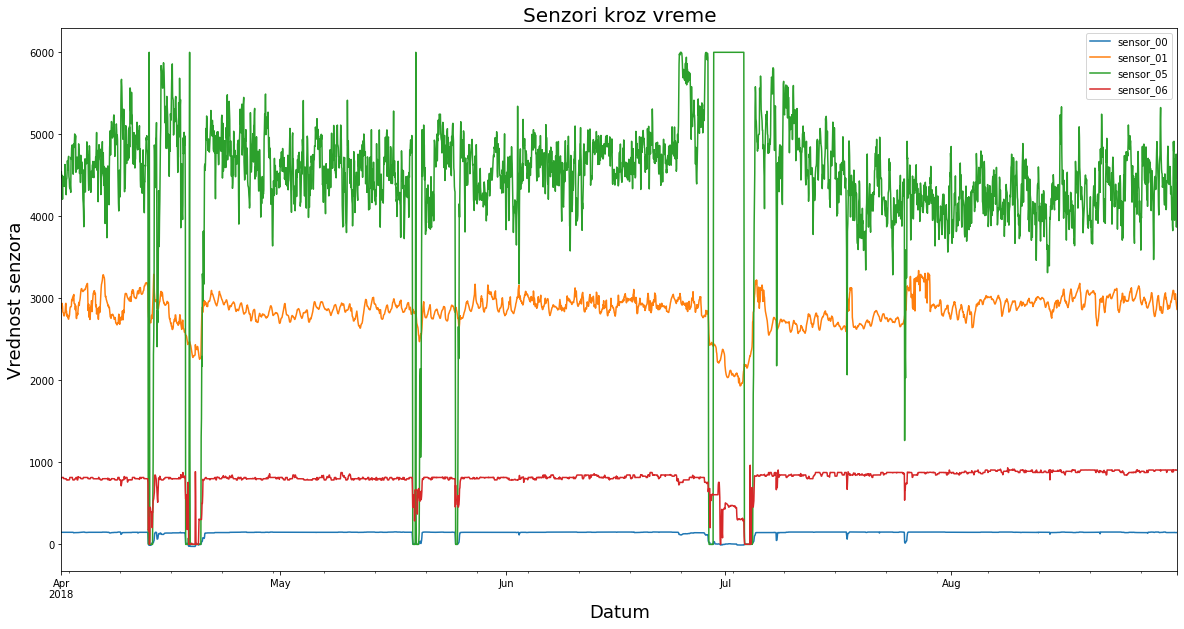

In [276]:
train_data[['sensor_00','sensor_01', 'sensor_05', 'sensor_06']].plot(figsize=(20,10))
plt.xlabel("Datum", fontsize=18)
plt.ylabel("Vrednost senzora", fontsize=18)
plt.title('Senzori kroz vreme', fontsize=20);

In [360]:
train_data_minute[train_data_minute['machine_status']=='BROKEN'].head(100)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.652800,BROKEN
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.738400,BROKEN
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.523100,BROKEN
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.361100,BROKEN
128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,169.719892,BROKEN
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.768500,BROKEN
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,269.655985,205.729200,BROKEN


- Conclusion based on visualization is that we can predict failure based on sensors, in this case the sensor_05 is the most valuable.

### Data preparation

In [278]:
train_data.reset_index(inplace=True)
train_data.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2018-04-01 00:00:00,147.270375,2913.36793,3188.541524,2773.524220,38047.2245,4544.18636,801.83005,969.72643,942.15136,...,1926.562367,2420.312290,2326.388814,3003.18286,2827.546320,2358.796255,11847.5114,4690.10433,14409.1439,12601.8518
1,2018-04-01 01:00:00,147.254637,2880.94611,3186.414793,2756.119694,38054.1663,4473.95323,815.58151,969.40087,942.76623,...,1973.176927,2392.708110,2593.171300,2839.98847,2632.523120,2358.217562,10841.1461,4403.06712,13819.7341,12224.2472
2,2018-04-01 02:00:00,147.217251,2939.58319,3180.642243,2735.590144,38065.6243,4501.01258,815.79850,969.64682,940.06800,...,1936.458200,2396.353953,2533.854110,3054.10881,2906.828722,2308.738394,10416.9562,4550.92593,13518.2288,12599.8262
3,2018-04-01 03:00:00,147.274309,2919.27078,3178.559090,2713.107514,38005.0193,4395.38262,816.26149,969.56000,941.31948,...,1878.906216,2377.603950,3048.900480,3224.82637,2733.506987,2300.057799,12263.3102,6278.35645,15438.9468,13360.8215
4,2018-04-01 04:00:00,147.227091,2899.60931,3172.091999,2707.855830,38099.1892,4208.99011,815.11132,969.08983,942.12968,...,1858.593658,2374.739390,3398.726830,4153.64580,3554.398130,2311.921252,12785.0114,6850.69434,14948.2059,12698.4953


- We will use first 4 months for training, and last month for validation

In [279]:
train = train_data[train_data['timestamp']<'2018-08-01']

validation = train_data[train_data['timestamp']>='2018-08-01']

In [280]:
train.shape

(2928, 52)

In [281]:
train.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
0,2018-04-01 00:00:00,147.270375,2913.36793,3188.541524,2773.524220,38047.2245,4544.18636,801.83005,969.72643,942.15136,...,1926.562367,2420.312290,2326.388814,3003.18286,2827.546320,2358.796255,11847.5114,4690.10433,14409.1439,12601.8518
1,2018-04-01 01:00:00,147.254637,2880.94611,3186.414793,2756.119694,38054.1663,4473.95323,815.58151,969.40087,942.76623,...,1973.176927,2392.708110,2593.171300,2839.98847,2632.523120,2358.217562,10841.1461,4403.06712,13819.7341,12224.2472
2,2018-04-01 02:00:00,147.217251,2939.58319,3180.642243,2735.590144,38065.6243,4501.01258,815.79850,969.64682,940.06800,...,1936.458200,2396.353953,2533.854110,3054.10881,2906.828722,2308.738394,10416.9562,4550.92593,13518.2288,12599.8262
3,2018-04-01 03:00:00,147.274309,2919.27078,3178.559090,2713.107514,38005.0193,4395.38262,816.26149,969.56000,941.31948,...,1878.906216,2377.603950,3048.900480,3224.82637,2733.506987,2300.057799,12263.3102,6278.35645,15438.9468,13360.8215
4,2018-04-01 04:00:00,147.227091,2899.60931,3172.091999,2707.855830,38099.1892,4208.99011,815.11132,969.08983,942.12968,...,1858.593658,2374.739390,3398.726830,4153.64580,3554.398130,2311.921252,12785.0114,6850.69434,14948.2059,12698.4953


In [282]:
validation.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
2928,2018-08-01 00:00:00,147.230036,2801.562487,3063.845301,2678.168323,38303.361921,4493.54035,869.84223,972.99619,939.98117,...,2049.218588,3066.92692,2584.49076,2329.282345,3201.099490,2964.409720,9242.4763,3133.68054,13464.583590,13889.4673
2929,2018-08-01 01:00:00,147.230036,2821.093628,3065.451200,2681.857540,38190.893693,4013.29951,866.36283,991.98499,955.83769,...,1984.374885,2955.46854,2640.62495,3719.907430,4301.793920,2788.773170,15960.6484,4204.86106,17250.476112,14663.7727
2930,2018-08-01 02:00:00,147.249712,2846.701303,3046.397440,2685.373054,38220.601546,3671.19048,876.87350,987.21784,944.13342,...,2001.562389,2708.07271,2743.92360,2515.895635,3160.011600,2861.689830,15202.5462,4163.48373,16597.123460,14078.1249
2931,2018-08-01 03:00:00,147.243815,2872.439148,3004.470410,2680.164829,38239.927658,3960.37201,876.29477,960.25021,940.49482,...,1980.989427,2655.98937,2918.69211,2292.824013,2720.794106,2363.136547,11897.8587,3627.31483,14174.164696,11703.4143
2932,2018-08-01 04:00:00,147.244798,2891.145778,2990.060679,2672.048538,38216.385665,3873.34124,876.98198,955.69294,940.42248,...,1992.187347,2608.85396,2896.12266,2658.564840,3043.981470,2377.893477,17701.6780,3533.27541,17296.574591,11565.1039


In [ ]:
input_train = train[features].values
input_validation = validation[features].values

In [382]:
input_train.shape

(2928, 51)

In [283]:
# define variables
time_periods_to_train_on = train['timestamp'].nunique()
number_of_rows = len(train)
number_of_entities = 1

time_periods_to_train_on_validation = validation['timestamp'].nunique()
number_of_rows_validation = len(validation)
number_of_entities_validation = 1

number_of_features = len(features)


In [ ]:
# input in LSTM must be 3D
lstm_input_train = input_train.reshape(number_of_entities,
                                       time_periods_to_train_on,
                                       number_of_features)
lstm_input_validation = input_validation.reshape(number_of_entities,
                                                 time_periods_to_train_on_validation,
                                                 number_of_features)

- Now we are scaling data. Many ML algorithms have better performance if variables are scaled.

- Scaling can be performed when features are in different ranges and different measures.

- Since our data is now 3D, we need to adapt scaler for 3D arrays.


The input data to an LSTM model is a 3-dimensional array. The shape of the array is samples x timesteps x features.
Let’s understand them:

1. samples: This is simply the number of observations, or in other words, the number of data points.

2. timesteps: LSTM models are meant to look at the past. Meaning, at time t the LSTM will process data up to 
(t-timesteps) to make a prediction.

3. features: It is the number of features present in the input data.

In [284]:
def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [285]:
def inverse_scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    
    Output
    X            Original scale 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.inverse_transform(X[i, :, :])
        
    return X

In [286]:
scaler = StandardScaler().fit(input_train)
lstm_scaled_input_train = scale(lstm_input_train, scaler)
lstm_scaled_input_validation = scale(lstm_input_validation, scaler)

In [308]:
lstm_scaled_input_train.shape

(1, 2928, 51)

In [307]:
lstm_scaled_input_validation.shape

(1, 744, 51)

### Modelling

Define NN architecture

Parameters for LSTM Autoencoder:

- **hidden_dim_first**: number of hidden layers in first LSTM

- **hidden_dim_second**: number of hidden layers in second LSTM

- **learning_rate**: Controls how much to change the model in response to the estimated error each time the model weights are updated

- **num_of_epochs**: An epoch is one learning cycle where the learner sees the whole training data set; the higher number, the greater possibility for better results in training.

- **batch_size**: Number of training examples utilized in one iteration.

- **kernel_initializer**: Initializer for the kernel weights matrix, used for the linear transformation of the inputs (you can find more details here: https://keras.io/api/layers/initializers/)

- **loss_function**: The objective that the Autoencoder tries to reach

- **activation_function**: Mathematical equations that determine the output of a neural network. The function is attached to each neuron in the network, and determines whether it should be activated (“fired”) or not


In [7]:
# define parameters for training
number_of_epochs = 20
batch_size = 6

In [330]:
model = Sequential()

# Encoder
model.add(LSTM(128, activation='relu', input_shape=(time_periods_to_train_on, # None za varijabilni shape
                                                    number_of_features),
               return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(time_periods_to_train_on))

# Decoder
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(number_of_features)))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_126 (LSTM)              (None, 2928, 128)         92160     
_________________________________________________________________
lstm_127 (LSTM)              (None, 64)                49408     
_________________________________________________________________
repeat_vector_35 (RepeatVect (None, 2928, 64)          0         
_________________________________________________________________
lstm_128 (LSTM)              (None, 2928, 64)          33024     
_________________________________________________________________
lstm_129 (LSTM)              (None, 2928, 128)         98816     
_________________________________________________________________
time_distributed_33 (TimeDis (None, 2928, 51)          6579      
Total params: 279,987
Trainable params: 279,987
Non-trainable params: 0
_______________________________________________

 Model training

In [331]:
lstm_autoencoder_history = model.fit(lstm_scaled_input_train,
                                    lstm_scaled_input_train,
                                    epochs=number_of_epochs,
                                    verbose=1).history

Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 1.0006
Epoch 2/20
1/1 [==============================] - 5s 5s/step - loss: 1.0002
Epoch 3/20
1/1 [==============================] - 4s 4s/step - loss: 1.0001
Epoch 4/20
1/1 [==============================] - 4s 4s/step - loss: 1.0000
Epoch 5/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 6/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 7/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 8/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 9/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 10/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 11/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 12/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 13/20
1/1 [==============================] - 5s 5s/step - loss: 1.0000
Epoch 14

- This vizualization show us how the model is learning during epochs and can help us to choose optimal number of epochs.

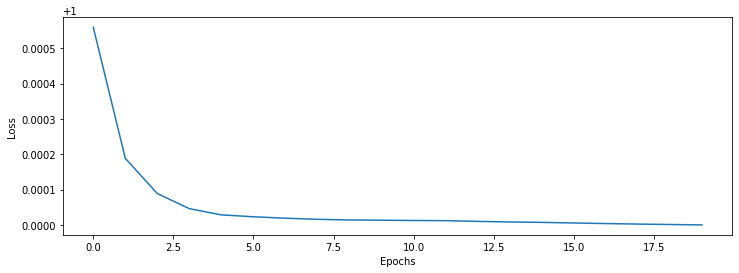

In [332]:
losses_lstm = lstm_autoencoder_history['loss']

plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(len(losses_lstm)),losses_lstm);

### Prediction

In [333]:
lstm_predictions = model.predict(lstm_scaled_input_train)

In [334]:
lstm_predictions = inverse_scale(lstm_predictions, scaler)

In [335]:
# back to 2D shape
predictions = lstm_predictions.reshape(number_of_rows, number_of_features)

In [361]:
predictions_df = pd.DataFrame(predictions, columns=features)
predictions_df['timestamp'] = train['timestamp'].values
predictions_df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,timestamp
0,132.756561,2832.576660,3038.947021,2606.925781,34766.605469,4433.221191,777.979065,926.108826,892.246033,874.431458,...,2612.506836,2444.907959,2483.726074,2750.283447,2628.239258,7475.724121,3167.330566,11641.132812,12243.546875,2018-04-01 00:00:00
1,132.740265,2832.461914,3038.891846,2606.966309,34760.367188,4433.379883,777.915405,926.034729,892.191223,874.398926,...,2612.187988,2444.772461,2483.636475,2750.554199,2628.046631,7477.463379,3168.193359,11639.574219,12242.128906,2018-04-01 01:00:00
2,132.725433,2832.301025,3038.838135,2606.945312,34756.273438,4433.708496,777.830200,926.018005,892.112671,874.396362,...,2611.933105,2444.677734,2483.508789,2750.775146,2628.003906,7479.762695,3168.732666,11637.206055,12242.459961,2018-04-01 02:00:00
3,132.714890,2832.130127,3038.784912,2606.881348,34754.101562,4434.067871,777.739746,926.048035,892.029846,874.398621,...,2611.769043,2444.561035,2483.366943,2750.900146,2628.022461,7481.883301,3168.989258,11634.356445,12244.197266,2018-04-01 03:00:00
4,132.709534,2831.970459,3038.734863,2606.790771,34753.136719,4434.412598,777.654358,926.107910,891.952820,874.397034,...,2611.681885,2444.415771,2483.217041,2750.945557,2628.059082,7483.627441,3169.022949,11631.325195,12247.029297,2018-04-01 04:00:00


### Evaluation

In [363]:
df_with_reconstructions = train.merge(predictions_df, on='timestamp',
                                   how='inner', suffixes=['', '_reconstructed'])

In [364]:
df_with_reconstructions.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42_reconstructed,sensor_43_reconstructed,sensor_44_reconstructed,sensor_45_reconstructed,sensor_46_reconstructed,sensor_47_reconstructed,sensor_48_reconstructed,sensor_49_reconstructed,sensor_50_reconstructed,sensor_51_reconstructed
0,2018-04-01 00:00:00,147.270375,2913.36793,3188.541524,2773.524220,38047.2245,4544.18636,801.83005,969.72643,942.15136,...,2153.299072,2612.506836,2444.907959,2483.726074,2750.283447,2628.239258,7475.724121,3167.330566,11641.132812,12243.546875
1,2018-04-01 01:00:00,147.254637,2880.94611,3186.414793,2756.119694,38054.1663,4473.95323,815.58151,969.40087,942.76623,...,2153.386475,2612.187988,2444.772461,2483.636475,2750.554199,2628.046631,7477.463379,3168.193359,11639.574219,12242.128906
2,2018-04-01 02:00:00,147.217251,2939.58319,3180.642243,2735.590144,38065.6243,4501.01258,815.79850,969.64682,940.06800,...,2153.326172,2611.933105,2444.677734,2483.508789,2750.775146,2628.003906,7479.762695,3168.732666,11637.206055,12242.459961
3,2018-04-01 03:00:00,147.274309,2919.27078,3178.559090,2713.107514,38005.0193,4395.38262,816.26149,969.56000,941.31948,...,2153.184326,2611.769043,2444.561035,2483.366943,2750.900146,2628.022461,7481.883301,3168.989258,11634.356445,12244.197266
4,2018-04-01 04:00:00,147.227091,2899.60931,3172.091999,2707.855830,38099.1892,4208.99011,815.11132,969.08983,942.12968,...,2153.016846,2611.681885,2444.415771,2483.217041,2750.945557,2628.059082,7483.627441,3169.022949,11631.325195,12247.029297


In [370]:
# calculate anomaly score for every feature
for feature in features:
    df_with_reconstructions[feature+'_anomaly_score'] = abs(df_with_reconstructions[feature] - \
                                                         df_with_reconstructions[feature+'_reconstructed'])

In [384]:
df_with_reconstructions.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42_anomaly_score,sensor_43_anomaly_score,sensor_44_anomaly_score,sensor_45_anomaly_score,sensor_46_anomaly_score,sensor_47_anomaly_score,sensor_48_anomaly_score,sensor_49_anomaly_score,sensor_50_anomaly_score,sensor_51_anomaly_score
0,2018-04-01 00:00:00,147.270375,2913.36793,3188.541524,2773.524220,38047.2245,4544.18636,801.83005,969.72643,942.15136,...,226.736706,192.194546,118.519145,519.456786,77.262873,269.443003,4371.787279,1522.773764,2768.011087,358.304925
1,2018-04-01 01:00:00,147.254637,2880.94611,3186.414793,2756.119694,38054.1663,4473.95323,815.58151,969.40087,942.76623,...,180.209547,219.479878,148.398839,356.351995,118.031079,269.829068,3363.682721,1234.873761,2180.159881,17.881706
2,2018-04-01 02:00:00,147.217251,2939.58319,3180.642243,2735.590144,38065.6243,4501.01258,815.79850,969.64682,940.06800,...,216.867972,215.579152,89.176376,570.600021,156.053576,319.265512,2937.193505,1382.193264,1881.022745,357.366239
3,2018-04-01 03:00:00,147.274309,2919.27078,3178.559090,2713.107514,38005.0193,4395.38262,816.26149,969.56000,941.31948,...,274.278111,234.165093,604.339445,741.459427,17.393160,327.964662,4781.426899,3109.367192,3804.590355,1116.624234
4,2018-04-01 04:00:00,147.227091,2899.60931,3172.091999,2707.855830,38099.1892,4208.99011,815.11132,969.08983,942.12968,...,294.423188,236.942495,954.311059,1670.428759,803.452573,316.137830,5301.383959,3681.671391,3316.880705,451.466003


In [377]:
# take just anomalies
anomaly_cols = [col for col in df_with_reconstructions.columns if 'anomaly' in col]
hourly_anomalies = pd.DataFrame(df_with_reconstructions[['timestamp']+anomaly_cols].set_index('timestamp').median(axis=1))

In [380]:
hourly_anomalies.sort_values(by=0, ascending=False).head(10)

,0
timestamp,
2018-06-28 18:00:00,4977.068457
2018-07-25 14:00:00,4192.967656
2018-06-28 22:00:00,3616.266446
2018-06-28 17:00:00,3362.797606
2018-06-28 20:00:00,3321.983966
2018-05-20 10:00:00,3231.602266
2018-05-20 09:00:00,3211.910353
2018-06-28 23:00:00,3204.802173
2018-07-24 00:00:00,3078.558775


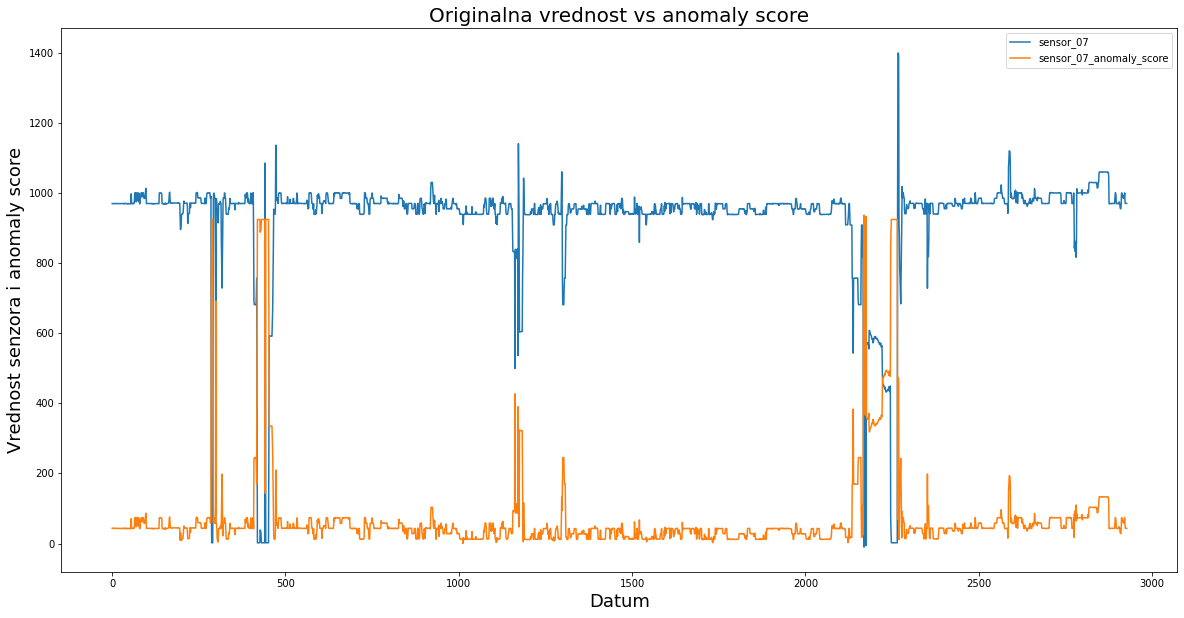

In [385]:
df_with_reconstructions[['sensor_07', 'sensor_07_anomaly_score']].plot(figsize=(20,10))
plt.xlabel("Date", fontsize=18)
plt.ylabel("Value of sensors and anomaly score", fontsize=18)
plt.title('Original value vs anomaly score', fontsize=20);